In [23]:
import acquire
import env4
import prepare

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import sklearn.preprocessing
from sklearn.model_selection import train_test_split

In [24]:
import pandas as pd
from prepare import train_test_validate2

def wrangle_zillow():
    """
    Perform data wrangling on Zillow dataset:
    1. Query relevant columns from the database.
    2. Save the data to a CSV file.
    3. Read the CSV file into a DataFrame.
    4. Check for and handle null values.
    5. Split the data into train, test, train_val, and test_val sets.

    Returns:
    - tuple: (train, test, train_val, test_val)
    """

    # Step 1: Query relevant columns from the database
    zillow_query = """
    SELECT bedroomcnt, bathroomcnt, calculatedfinishedsquarefeet,
           taxvaluedollarcnt, yearbuilt, taxamount, fips
    FROM propertylandusetype
    LEFT JOIN properties_2017 USING(propertylandusetypeid)
    WHERE propertylandusedesc = "Single Family Residential";
    """

    # Reading the data
    data = pd.read_sql(zillow_query, env4.get_db_url('zillow'))
    
    # Step 2: Save the data to a CSV file
    data.to_csv('zillow.csv')

    # Step 3: Read the CSV file into a DataFrame
    data = pd.read_csv('zillow.csv', index_col=0)

    # Step 4: Check for and handle null values
    data = data.dropna()
    
    #Turning floats into int

    make_ints = ['bedroomcnt', 'calculatedfinishedsquarefeet', 'taxvaluedollarcnt', 'yearbuilt', 'fips']

    for i in make_ints:
        data[i] = data[i].astype(int)
    

    # Step 5: Split the data into train, test, train_val, and test_val sets
    train, test, train_val, test_val = train_test_validate2(data)

    return train, test, train_val, test_val




In [25]:
# Example usage:
train, test, train_val, test_val = wrangle_zillow()



In [26]:
train.head()

,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt,yearbuilt,taxamount,fips
2093695,2,1.0,872,610263,1938,7430.97,6037
236593,3,1.0,1024,239025,1951,3619.29,6037
119786,3,2.0,1460,254089,1956,3250.40,6037
391140,4,2.0,1638,400706,1968,4986.75,6037
1311872,4,2.0,2064,177906,1964,2383.37,6037


In [ ]:
('LA':1, 'Orange':2, 'Ventura':3)

In [27]:
train.fips.unique()

array([6037, 6059, 6111])

In [31]:
#Changing fips to county (object)

# Dictionary mapping
fips_mapping = {6037: 'LA', 6059: 'Orange', 6111: 'Ventura'}


# Create a new column 'County_Name' based on the mapping
train['county'] = train['fips'].map(fips_mapping)

#OR train['county'] = train['fips'].map(fips_mapping)

In [28]:
#Changing fips to county (int)

# Dictionary mapping
fips_mapping = {6037: '1', 6059: '2', 6111: '3'}


# Create a new column 'County_Name' based on the mapping
train['county'] = train['fips'].map(fips_mapping)

#OR train['county'] = train['fips'].map(fips_mapping)

In [32]:
train.county.value_counts()

LA         1140078
Orange      442057
Ventura     130053
Name: county, dtype: int64

In [33]:
import pandas as pd  


# Create a new column 'County_Name' based on the mapping    --use if not mapped previously
#train['county'] = train['fips'].map(fips_mapping)

# Use get_dummies for one-hot encoding
encoded_county = pd.get_dummies(train['county'], prefix='County')

# Join the encoded values to the original DataFrame
train_encoded = pd.concat([train, encoded_county], axis=1)

# Display the updated DataFrame
print(train_encoded)


         bedroomcnt  bathroomcnt  calculatedfinishedsquarefeet  \
2093695           2          1.0                           872   
236593            3          1.0                          1024   
119786            3          2.0                          1460   
391140            4          2.0                          1638   
1311872           4          2.0                          2064   
...             ...          ...                           ...   
1966409           3          2.0                          2344   
1248304           4          3.0                          2162   
28216             3          2.0                          1228   
279546            4          3.0                          1966   
778194            3          3.0                          2589   

         taxvaluedollarcnt  yearbuilt  taxamount  fips  county  County_LA  \
2093695             610263       1938    7430.97  6037      LA          1   
236593              239025       1951    3619.29  603

In [34]:
train_encoded = train_encoded.drop('county', axis=1)

In [37]:
train_encoded.head()

,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt,yearbuilt,taxamount,fips,County_LA,County_Orange,County_Ventura
2093695,2,1.0,872,610263,1938,7430.97,6037,1,0,0
236593,3,1.0,1024,239025,1951,3619.29,6037,1,0,0
119786,3,2.0,1460,254089,1956,3250.40,6037,1,0,0
391140,4,2.0,1638,400706,1968,4986.75,6037,1,0,0
1311872,4,2.0,2064,177906,1964,2383.37,6037,1,0,0


In [43]:
#Fitting the data to X[dependent features], and y[Independent feature]
X_train = train_encoded.drop(['taxvaluedollarcnt'], axis=1)

X_test = test_encoded.drop(['taxvaluedollarcnt'], axis=1)

y_train = train_encoded['taxvaluedollarcnt']

y_test = test_encoded['taxvaluedollarcnt']    #Still need ot encode for test and validate set

In [46]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1712188, 9), (1712188, 9), (1712188,), (1712188,))

### Scaling Features

In [44]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

In [47]:
scaler = StandardScaler()
MinMax = MinMaxScaler()
robust = RobustScaler()

In [48]:
X_train_scaled = MinMax.fit_transform(X_train)
X_test_scaled = MinMax.fit_transform(X_test)

In [52]:
#Comparing tables
X_train2 = X_train.reset_index(drop=True)
X_train2

,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,yearbuilt,taxamount,fips,County_LA,County_Orange,County_Ventura
0,2,1.0,872,1938,7430.97,6037,1,0,0
1,3,1.0,1024,1951,3619.29,6037,1,0,0
2,3,2.0,1460,1956,3250.40,6037,1,0,0
3,4,2.0,1638,1968,4986.75,6037,1,0,0
4,4,2.0,2064,1964,2383.37,6037,1,0,0
...,...,...,...,...,...,...,...,...,...
1712183,3,2.0,2344,1940,5074.13,6037,1,0,0
1712184,4,3.0,2162,1964,6039.82,6037,1,0,0
1712185,3,2.0,1228,1955,5875.70,6059,0,1,0
1712186,4,3.0,1966,1956,2236.15,6037,1,0,0


In [51]:
# Create a DataFrame from the scaled data with appropriate column labels
X_train_scaled_df = pd.DataFrame(X_test_scaled, columns=X_train.columns)

# Display the DataFrame
#print(X_scaled_df)
X_train_scaled_df

,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,yearbuilt,taxamount,fips,County_LA,County_Orange,County_Ventura
0,0.111111,0.03125,0.000914,0.637209,0.006887,0.000000,1.0,0.0,0.0
1,0.166667,0.03125,0.001074,0.697674,0.003351,0.000000,1.0,0.0,0.0
2,0.166667,0.06250,0.001532,0.720930,0.003009,0.000000,1.0,0.0,0.0
3,0.222222,0.06250,0.001718,0.776744,0.004620,0.000000,1.0,0.0,0.0
4,0.222222,0.06250,0.002166,0.758140,0.002205,0.000000,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
1712183,0.166667,0.06250,0.002460,0.646512,0.004701,0.000000,1.0,0.0,0.0
1712184,0.222222,0.09375,0.002269,0.758140,0.005596,0.000000,1.0,0.0,0.0
1712185,0.166667,0.06250,0.001288,0.716279,0.005444,0.297297,0.0,1.0,0.0
1712186,0.222222,0.09375,0.002063,0.720930,0.002068,0.000000,1.0,0.0,0.0


In [69]:
#2. Apply the .inverse_transform method to your scaled data.

X_inverse_scaled = pd.DataFrame(MinMax.inverse_transform(X_train_scaled), columns=X_train.columns)
X_inverse_scaled

,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,yearbuilt,taxamount,fips,County_LA,County_Orange,County_Ventura
0,2.0,1.0,872.0,1938.0,7430.97,6037.0,1.0,0.0,0.0
1,3.0,1.0,1024.0,1951.0,3619.29,6037.0,1.0,0.0,0.0
2,3.0,2.0,1460.0,1956.0,3250.40,6037.0,1.0,0.0,0.0
3,4.0,2.0,1638.0,1968.0,4986.75,6037.0,1.0,0.0,0.0
4,4.0,2.0,2064.0,1964.0,2383.37,6037.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
1712183,3.0,2.0,2344.0,1940.0,5074.13,6037.0,1.0,0.0,0.0
1712184,4.0,3.0,2162.0,1964.0,6039.82,6037.0,1.0,0.0,0.0
1712185,3.0,2.0,1228.0,1955.0,5875.70,6059.0,0.0,1.0,0.0
1712186,4.0,3.0,1966.0,1956.0,2236.15,6037.0,1.0,0.0,0.0


In [ ]:
#The transformed data types turn into all float64 instead of the original int64 dta types

In [72]:
X_inverse_scaled.dtypes

bedroomcnt                      float64
bathroomcnt                     float64
calculatedfinishedsquarefeet    float64
yearbuilt                       float64
taxamount                       float64
fips                            float64
County_LA                       float64
County_Orange                   float64
County_Ventura                  float64
dtype: object

In [73]:
X_train.dtypes

bedroomcnt                        int64
bathroomcnt                     float64
calculatedfinishedsquarefeet      int64
yearbuilt                         int64
taxamount                       float64
fips                              int64
County_LA                         uint8
County_Orange                     uint8
County_Ventura                    uint8
dtype: object

<Axes: >

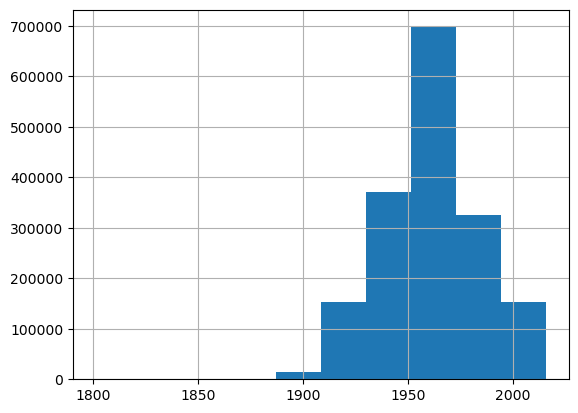

In [84]:
#3. Read the documentation for sklearn's QuantileTransformer. 
#Use normal for the output_distribution and apply this scaler to your data. 
#Visualize the result of your data scaling.

X_train.yearbuilt.hist()

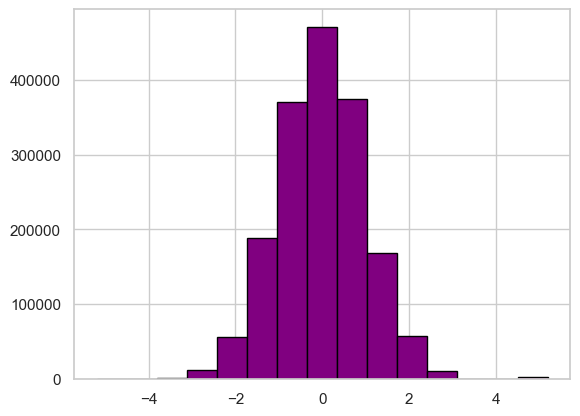

In [101]:
from sklearn.preprocessing import QuantileTransformer
from numpy.random import randn
from sklearn.preprocessing import QuantileTransformer
from matplotlib import pyplot

# quantile transform the raw data
quantile = QuantileTransformer(output_distribution='normal')
data_trans = quantile.fit_transform(X_train[['yearbuilt']])
# histogram of the transformed data
pyplot.hist(data_trans, bins=15,  edgecolor='black', color='purple')
pyplot.show()

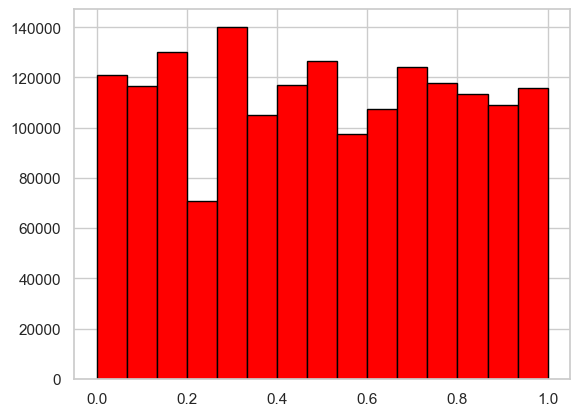

In [112]:
# Set seaborn style to default
sns.set(style="whitegrid")

#4. Use the QuantileTransformer, but omit the output_distribution argument. 
#Visualize your results. What do you notice?

quantile2 = QuantileTransformer(output_distribution='uniform')


# quantile transform the raw data
data_trans_uniform = quantile2.fit_transform(X_train[['yearbuilt']])
# histogram of the transformed data
pyplot.hist(data_trans_uniform, bins=15, color='red', edgecolor='black')
pyplot.show()

In [97]:
#5. Based on the work you've done, choose a scaling method for your dataset. 
#Write a function within your prepare.py that accepts as input the train, validate, and test data splits, and returns the scaled versions of each. 
#Be sure to only learn the parameters for scaling from your training data!


import pandas as pd
from sklearn.preprocessing import StandardScaler

def scaling_dataframe(train, validate, test, fill_value=0):
    """
    Preprocess a DataFrame by scaling specified columns and filling/replacing NaN values.

    Parameters:
    - train (pd.DataFrame): Training DataFrame.
    - validate (pd.DataFrame): Validation DataFrame.
    - test (pd.DataFrame): Test DataFrame.
    - fill_value (int or float): Value to fill NaN entries in the DataFrames.

    Returns:
    - tuple: Tuple containing the scaled versions of train, validate, and test DataFrames.
    """

    # olumns to scale
    columns_to_scale = ['yearbuilt']  

    # Scaling Data
    scaler = StandardScaler()

    # Fit the scaler on the training data and transform all datasets
    train_scaled = pd.DataFrame(scaler.fit_transform(train[columns_to_scale]), columns=columns_to_scale)
    validate_scaled = pd.DataFrame(scaler.transform(validate[columns_to_scale]), columns=columns_to_scale)
    test_scaled = pd.DataFrame(scaler.transform(test[columns_to_scale]), columns=columns_to_scale)

    # Filling/Replacing NaN values with the specified fill value
    train_scaled = train_scaled.fillna(fill_value)
    validate_scaled = validate_scaled.fillna(fill_value)
    test_scaled = test_scaled.fillna(fill_value)

    return train_scaled, validate_scaled, test_scaled

# Example usage:
# train_scaled, validate_scaled, test_scaled = scaling_dataframe(train, validate, test)



In [98]:
train_scaled, validate_scaled, test_scaled = scaling_dataframe(train, train_val, test)


In [99]:
validate_scaled

,yearbuilt
0,1.806805
1,0.407561
2,0.317287
3,0.407561
4,-0.585452
...,...
856089,-0.134082
856090,1.987353
856091,-0.404904
856092,-0.495178


In [ ]:
#Scaling for single feature

min_max_scaler = sklearn.preprocessing.MinMaxScaler()
min_max_scaler.fit(train[['monthly_charges']])

train['monthly_charges_scaled'] = min_max_scaler.transform(train[['monthly_charges']])
test['monthly_charges_scaled'] = min_max_scaler.transform(test[['monthly_charges']])
validate['monthly_charges_scaled'] = min_max_scaler.transform(validate[['monthly_charges']

In [ ]:
#Data scaling for mulitple features

variable_columns = ['transaction_dollar_amount', 'Long', 'Lat', 'credit_card_limit' ]

scaler = StandardScaler()
df[variable_columns] = scaler.fit_transform(df[variable_columns])
df[variable_columns]